In [5]:
#import albumentations as A
#from albumentations.pytorch import ToTensorV2
import numpy as np
import rasterio as rio
import matplotlib.pyplot as plt
import torch
import tensorflow as tf
from rasterio.plot import show
import pandas as pd
#import torchvision
%matplotlib inline

-0.20027386
3.9575264


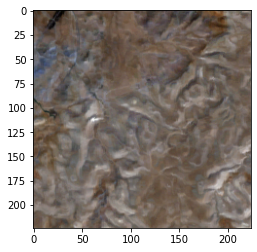

<AxesSubplot:>

In [39]:
img_path = "/cephyr/NOBACKUP/groups/globalpoverty1/Kakooei/DatasetAfricaPoverty/TenYears/Geo0/0000012768-0000011872.tif"
img_src = rio.open(img_path)
img_numpy = img_src.read()
print(np.min(img_numpy[(2,1,0),:,:]))
print(np.max(img_numpy[(2,1,0),:,:]))
img_tensor = torch.from_numpy(img_numpy)
show(img_numpy[(2,1,0),:,:], adjust=True)

In [11]:
dhs_clusters = pd.read_csv('/cephyr/NOBACKUP/groups/globalpoverty1/JesperBenjamin/Supervised/dhs_clusters_paths.csv')
tf_path = dhs_clusters.iloc[0][9]
tf_path



'/cephyr/NOBACKUP/groups/globalpoverty1/data/dhs_tfrecords/angola_2006/00000.tfrecord.gz'

In [34]:
bands = ['BLUE', 'GREEN', 'RED', 'SWIR1', 'SWIR2', 'TEMP1', 'NIR', 'NIGHTLIGHTS']
n_temporal_frames = 10
keys_to_features = {}
for band in bands:
    keys_to_features[band] = tf.io.FixedLenFeature(shape=[224 ** 2 * n_temporal_frames], dtype=tf.float32)
scalar_float_keys = ['lat', 'lon', 'year', 'iwi']
for key in scalar_float_keys:
    keys_to_features[key] = tf.io.FixedLenFeature(shape=[], dtype=tf.float32)

# Get means and stds for all data instead of per split?
band_means = [0.06614169065743208,
    0.09635988259340068,
    0.11381173286380034,
    0.2403052018705142,
    0.169467635861788,
    281.2976763110107,
    0.24095368620456603,
    13.069690484896771,
    5.075756473790338]

band_stds = [
    0.03512808462999218,
    0.050729950158437294,
    0.07239252056994558,
    0.12444550248291769,
    0.10850729467914068,
    71.28094889057179,
    0.09077465132496389,
    18.566259343422725,
    15.861609457767129
    ]

def year_to_index( year):
    year = year - 1990
    year = int(year/3)

    return year

dataset = tf.data.TFRecordDataset(
            filenames=tf_path,
            compression_type='GZIP')

for i, example_proto in enumerate(dataset):
    ex = tf.io.parse_example(example_proto, features=keys_to_features)

for band in bands:    
    ex[band] = tf.reshape(ex[band], (n_temporal_frames, 224, 224))

img_data = np.empty((8,224,224))
for i, k in enumerate(ex):
    #print("enumerate example proto, index: ", i, " key: ", k)
    #info = nvidia_smi.nvmlDeviceGetMemoryInfo(handle)
    #print("Total memory:", info.total)
    #print("Free memory:", info.free)
    #print("Used memory:", info.used)
    #print()

    band_index = bands.index(k)
    #print(ex['year'])
    composite_index = year_to_index(ex['year'])
    #print(composite_index)

    # Normalize data

    if k == 'NIGHTLIGHTS': 
        if ex['year'] > 2015:
            composite = (ex[k][composite_index] - band_means[8]) / band_stds[8]
            img_data[band_index] = composite.numpy()
        else:
            composite = (ex[k][composite_index] - band_means[7]) / band_stds[7]
            img_data[band_index] = composite.numpy()

    else:
        composite = (ex[k][composite_index] - band_means[band_index]) / band_stds[band_index]
        img_data[band_index] = composite.numpy()

    # Only get first 8 entries, i.e. all image bands
    if i >= 7:
        break

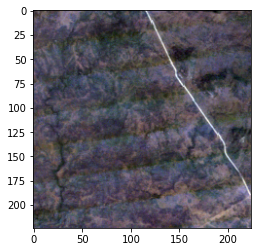

-1.1214991807937622
0.8758435845375061


array([[[-0.13498281, -0.26877892, -0.23746495, ..., -0.2431584 ,
         -0.28016582, -0.27731904],
        [-0.17626028, -0.21469109, -0.18622388, ..., -0.23746495,
         -0.30009291, -0.28585926],
        [-0.17768367, -0.22607797, -0.23177151, ..., -0.14921646,
         -0.16914356, -0.30293956],
        ...,
        [-0.17199023, -0.15206313, -0.11505571, ...,  0.07140476,
          0.00450665, -0.05385115],
        [-0.15490991, -0.14779308, -0.13782959, ...,  0.08706181,
         -0.04388765, -0.00972679],
        [-0.1463697 , -0.16914356,  0.0187403 , ...,  0.2322447 ,
          0.05574772,  0.02158708]],

       [[-0.43287814, -0.45948964, -0.43682066, ..., -0.42499328,
         -0.41513714, -0.42203638],
        [-0.35304362, -0.41119477, -0.36782789, ..., -0.43682066,
         -0.48215866, -0.42696452],
        [-0.35994285, -0.37571275, -0.41316587, ..., -0.33628824,
         -0.39542487, -0.41415152],
        ...,
        [-0.45061913, -0.38359764, -0.31460488, ..., -

In [35]:

show(img_data[(2,1,0),:,:], adjust=True)
print(np.min(img_data))
print(np.max(img_data))
img_data

In [20]:
with tf.device('/cpu:0'):

    bands = ['BLUE', 'GREEN', 'RED', 'SWIR1', 'SWIR2', 'TEMP1', 'NIR', 'NIGHTLIGHTS']
    n_temporal_frames = 10
    keys_to_features = {}
    for band in bands:
        keys_to_features[band] = tf.io.FixedLenFeature(shape=[224 ** 2 * n_temporal_frames], dtype=tf.float32)
    scalar_float_keys = ['lat', 'lon', 'year', 'iwi']
    for key in scalar_float_keys:
        keys_to_features[key] = tf.io.FixedLenFeature(shape=[], dtype=tf.float32)

    # Parse and print all 13 samples

    for i, example_proto in enumerate(dataset):
        ex = tf.io.parse_single_example(example_proto, features=keys_to_features)

        print(f'\nLocation nr. {i}')

        # Reshape to (10, 224, 224)
        for band in bands:
            ex[band] = tf.reshape(ex[band], (n_temporal_frames, 224, 224))

        # Print the value for all scalar_float_keys, but only the mean/shape for the bands
        for key in ex.keys():
            if key in bands:
                band_frames = ex[key].numpy()
                print(f'{key}: mean={band_frames.mean():.3f}, shape={band_frames.shape}')
            else:
                # key in scalar_float_keys
                print(f'{key}: {ex[key].numpy()}')
        print('')


Location nr. 0
BLUE: mean=0.058, shape=(10, 224, 224)
GREEN: mean=0.080, shape=(10, 224, 224)
NIGHTLIGHTS: mean=2.261, shape=(10, 224, 224)
NIR: mean=0.216, shape=(10, 224, 224)
RED: mean=0.087, shape=(10, 224, 224)
SWIR1: mean=0.229, shape=(10, 224, 224)
SWIR2: mean=0.145, shape=(10, 224, 224)
TEMP1: mean=297.973, shape=(10, 224, 224)
iwi: 68.09629821777344
lat: -12.169282913208008
lon: 13.859254837036133
year: 2006.0

